## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os                                                                       
import numpy as np                                                              
import tensorflow as tf                                                         
import data.data_selector as ds                                                   
import analysis.analysis_picker as ap
import utils.plot_functions as pf                                               

## Model parameters

In [3]:
analysis_params = {
  "model_type": "lca_pca_fb",
  "model_name": "lca_pca_fb_pretrain",
  "suffix": "300k_imgs",
  "version": "0.0",
  "device": "/gpu:0",
  "cov_num_images": int(3e5), #number of images used to compute cov matrix
  "ft_padding": 32, #Fourier analysis padding
  "data_type": "vanhateren",
  "clobber": True}

# Computed params
analysis_params["model_dir"] = (os.path.expanduser("~")+"/Work/Projects/"
  +analysis_params["model_name"])

## Load dataset and analyzer

In [4]:
analyzer = ap.get_analyzer(analysis_params)

In [5]:
if analysis_params["clobber"]:
  analyzer.model_params["data_type"] = analysis_params["data_type"]
  data = ds.get_data(analyzer.model_params)
  analyzer.model_params["input_shape"] = [                                                       
    data["train"].num_rows*data["train"].num_cols*data["train"].num_channels]     

In [6]:
if analysis_params["clobber"]:
  analyzer.run_analysis(data["train"].images[:analysis_params["cov_num_images"], ...],
    save_info=analysis_params["suffix"])
else:
  analyzer.load_analysis(save_info=analysis_params["suffix"])

## Construct analysis plots

### Run statistics

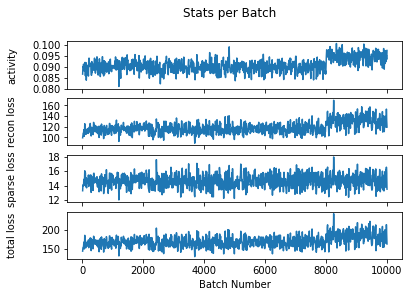

In [7]:
fig = pf.plot_stats(analyzer.run_stats,
  keys=["a_fraction_active", "recon_loss", "sparse_loss", "total_loss"],
  labels=["activity", "recon loss", "sparse loss", "total loss"])
fig.savefig(analyzer.analysis_out_dir+"fig_run_stats.png")

### Neural inputs during inference

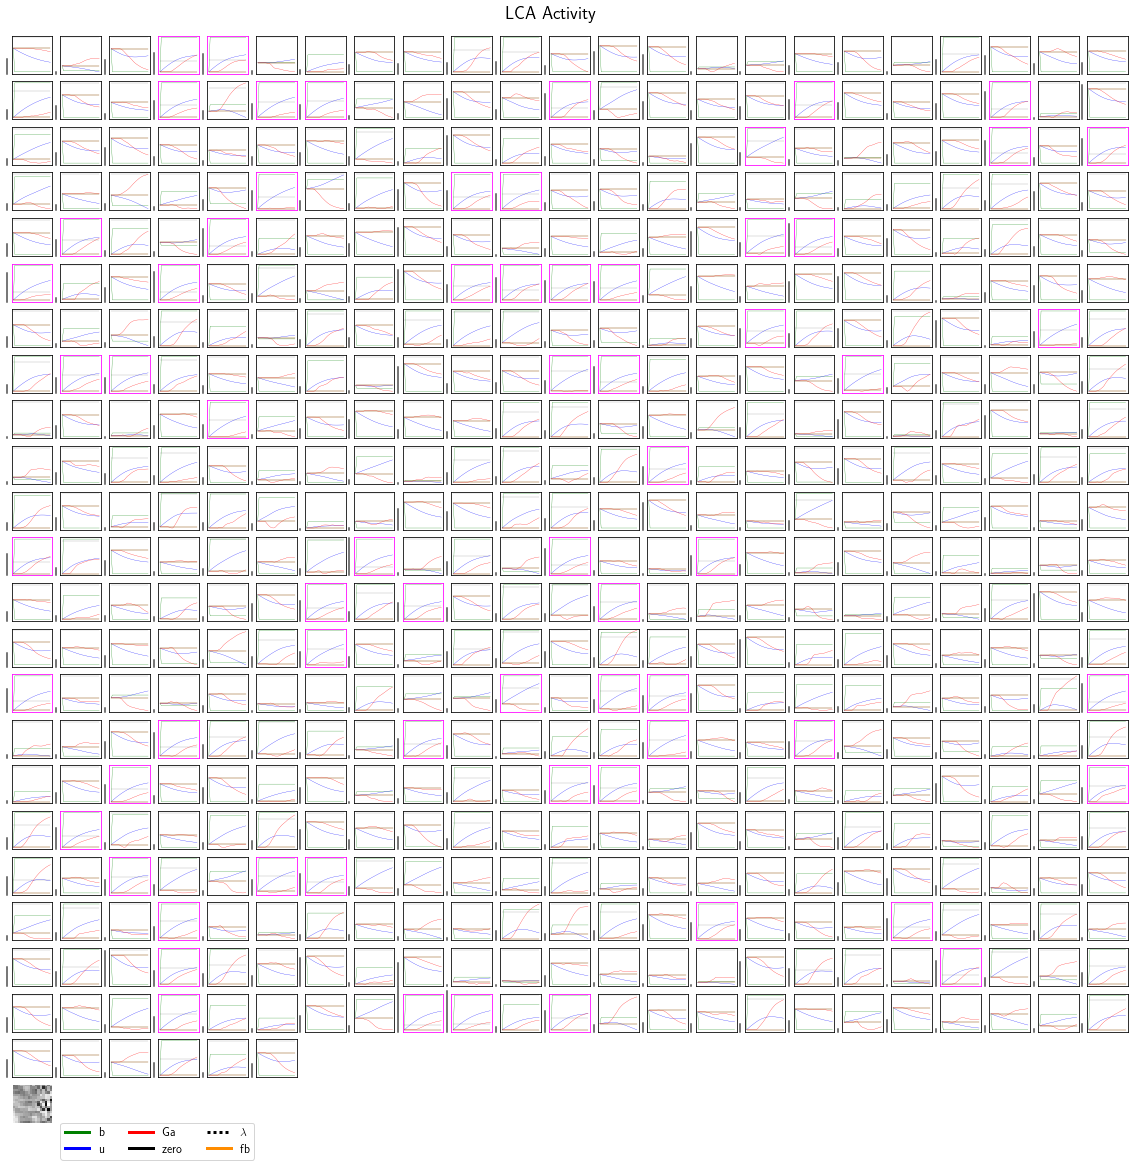

In [8]:
fig = pf.plot_inference_traces(analyzer.inference_stats, analyzer.model_schedule[0]["sparse_mult"], 0)
fig.savefig(analyzer.analysis_out_dir+"fig_inference_traces.pdf")

### Activity triggered averages

In [ ]:
num_pixels, num_neurons = analyzer.atas.shape
fig = pf.plot_data_tiled(analyzer.atas.T.reshape(num_neurons,
  int(np.sqrt(num_pixels)), int(np.sqrt(num_pixels))), normalize=False,
  title="Activity triggered averages on image data")
fig.savefig(analyzer.analysis_out_dir+"fig_l1_atas.png")

In [ ]:
num_pixels, num_neurons = analyzer.evec_atas.shape
fig = pf.plot_data_tiled(analyzer.evec_atas.T.reshape(num_neurons,
  int(np.sqrt(num_pixels)), int(np.sqrt(num_pixels))), normalize=True,
  title="Eigen Vector activity triggered averages on image data")
fig.savefig(analyzer.analysis_out_dir+"fig_atas_eigen.png")

In [ ]:
def plot_weights(weights):
  num_plots = weights.shape[0]
  num_plots_y = int(np.ceil(np.sqrt(num_plots))+1)
  num_plots_x = int(np.floor(np.sqrt(num_plots)))
  fig, sub_ax = plt.subplots(num_plots_y, num_plots_x, figsize=(18,18))
  filter_total = 0
  for plot_id in  np.ndindex((num_plots_y, num_plots_x)):
    if filter_total < num_plots:
      sub_ax[plot_id].imshow(weights[filter_total, ...], cmap="Greys_r")
      filter_total += 1
    pf.clear_axis(sub_ax[plot_id])
    sub_ax[plot_id].set_aspect("equal")
  plt.show()
  return fig

In [ ]:
import matplotlib.pyplot as plt
num_pixels, num_neurons = analyzer.evec_atas.shape
fig = plot_weights(analyzer.evec_atas.T.reshape(num_neurons, int(np.sqrt(num_pixels)), int(np.sqrt(num_pixels))))
fig.savefig(analyzer.analysis_out_dir+"fig_atas_evec.png")

In [ ]:
num_pixels, num_neurons = analyzer.pool_atas.shape
fig = plot_weights(analyzer.pool_atas.T.reshape(num_neurons, int(np.sqrt(num_pixels)), int(np.sqrt(num_pixels))))
fig.savefig(analyzer.analysis_out_dir+"fig_atas_pool.png")

### Activity covariance matrix summaries

In [ ]:
fig = pf.plot_cov_matrix(analyzer.cov["act_cov"], str(analysis_params["cov_num_images"]))
fig.savefig(analyzer.analysis_out_dir+"fig_covariance_matrix.png")

In [ ]:
fig = pf.plot_eigenvalues(analyzer.cov["a_eigvals"], ylim=[0,100])
fig.savefig(analyzer.analysis_out_dir+"fig_eigenvalues.png")

In [ ]:
num_random_bases = 10
num_top_cov_bases = 10
bf_indices = np.random.choice(np.arange(analyzer.cov["act_cov"].shape[0]), num_random_bases)
fig = pf.plot_top_bases(analyzer.cov["act_cov"], analyzer.evals["weights/phi:0"],
  bf_indices, num_top_cov_bases)
fig.savefig(analyzer.analysis_out_dir+"fig_top_cov_bases.png")

### Basis function analysis

In [ ]:
fig = pf.plot_hilbert_analysis(analyzer.evals["weights/phi:0"], analysis_params["ft_padding"])
fig.savefig(analyzer.analysis_out_dir+"fig_hilbert_analysis.png")

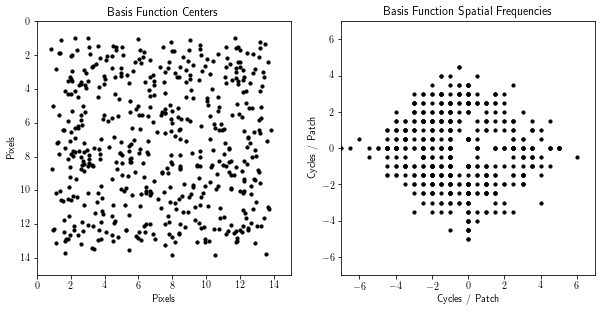

In [9]:
fig = pf.plot_loc_freq_summary(analyzer.bf_stats)
fig.savefig(analyzer.analysis_out_dir+"fig_location_frequency_centers.png")

In [ ]:
fig = pf.plot_bf_stats(analyzer.bf_stats, num_bf=10)
fig.savefig(analyzer.analysis_out_dir+"fig_basis_function_summary_stats.png")

In [ ]:
fig = pf.plot_gaussian_contours(analyzer.bf_stats, num_plots=128)
fig.savefig(analyzer.analysis_out_dir+"fig_gauss_contours.png")

### Pooling and eigen summary plots

In [ ]:
fig = pf.plot_ellipse_summaries(analyzer.bf_stats, num_bf=1000, lines=True)
fig.savefig(analyzer.analysis_out_dir+"fig_ellipse_fitting_summary.png")

In [ ]:
num_pooling_filters = 64 # How many 2nd layer filters to display
num_connected_weights = analyzer.model.num_neurons # How many of strongest connected weight summaries to show
fig = pf.plot_pooling_summaries(analyzer.bf_stats, analyzer.cov["a_eigvecs"],
  num_pooling_filters, num_connected_weights, lines=True)
fig.savefig(analyzer.analysis_out_dir+"fig_eigen_pooling_lines.png")

In [ ]:
num_pooling_filters = 64
fig_size = (10, 10)
spot_size = 60
fig = pf.plot_pooling_centers(analyzer.bf_stats, analyzer.cov["a_eigvecs"],
  num_pooling_filters, fig_size, spot_size)
fig.savefig(analyzer.analysis_out_dir+"fig_eigen_pooling_centers.png", bbox_inches="tight")

In [ ]:
num_pooling_filters = 25
num_connected_weights = analyzer.model.num_neurons
fig = pf.plot_pooling_summaries(analyzer.bf_stats, analyzer.cov["pooling_filters"], num_pooling_filters,
  num_connected_weights, lines=True)
fig.savefig(analyzer.analysis_out_dir+"fig_reduc_pooling_lines.png")

In [ ]:
num_pooling_filters = 25
fig_size = (10, 10)
spot_size = 60
fig = pf.plot_pooling_centers(analyzer.bf_stats, analyzer.cov["pooling_filters"], num_pooling_filters,
  fig_size, spot_size)
fig.savefig(analyzer.analysis_out_dir+"fig_reduc_pooling_centers.png", bbox_inches="tight")